In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0, '../scripts')
from utils import *

In [ ]:
plt.style.use('seaborn')

In [2]:
plt.rcParams['figure.figsize'] = (12, 10)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using MXNet backend.


In [5]:
import datetime
import time

In [6]:
from keras.models import Model
from keras.layers import (Input, Bidirectional, LSTM, Merge, Flatten, Dense, Reshape, Dropout,
                          BatchNormalization, Lambda)
from keras.layers.advanced_activations import PReLU
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.engine.topology import merge

In [7]:
train_data = pd.read_csv('../data/clean-train.csv').dropna(axis=0)
test_data = pd.read_csv('../data/clean-test.csv').dropna(axis=0)

In [8]:
q1_list = train_data['q1'].tolist()
q2_list = train_data['q2'].tolist()

In [47]:
q1_list_test = test_data['q1'].tolist()
q2_list_test = test_data['q2'].tolist()

In [9]:
vocab_size = 10000

In [10]:
token = Tokenizer(nb_words=vocab_size)
token.fit_on_texts(q1_list + q2_list)

In [11]:
question1_seq = token.texts_to_sequences(q1_list)
question2_seq = token.texts_to_sequences(q2_list)

In [48]:
question1_seq_test = token.texts_to_sequences(q1_list_test)
question2_seq_test = token.texts_to_sequences(q2_list_test)

In [12]:
MAX_SEQUENCE_LENGTH = 25

In [13]:
q1_data = pad_sequences(question1_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [49]:
q1_data_test = pad_sequences(question1_seq_test, maxlen=MAX_SEQUENCE_LENGTH)
q2_data_test = pad_sequences(question2_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
train_labels = train_data['is_same'].values

In [50]:
test_labels = test_data['is_same'].values

In [15]:
MAX_SEQUENCE_LENGTH = 25
WORD_EMBEDDING_DIM = 300
SENT_EMBEDDING_DIM = 128
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 150
DROPOUT = 0.2
BATCH_SIZE = 516
nb_words = vocab_size

In [16]:
gpus = 8
gpu_list = []
for i in range(gpus):
    gpu_list.append('gpu({:.0f})'.format(i))

In [41]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q2)

angle = merge([q1,q2], mode='dot', dot_axes=1)
angle = Flatten()(angle)
angle = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(angle)
angle = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(angle)

minus_q2 = Lambda(lambda x: -x)(q2)
distance = merge([q1,minus_q2], mode='sum', dot_axes=1)
distance = Flatten()(distance)
distance = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(distance)
distance = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(distance)

merged = merge([q1,angle, distance], mode='concat', concat_axis=1)
merged = Flatten()(merged)
merged = Dense(200)(merged)
merged = PReLU()(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200)(merged)
merged = PReLU()(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200)(merged)
merged = PReLU()(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200)(merged)
merged = PReLU()(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

/home/ubuntu/src/anaconda3/envs/keras1.2_p3/lib/python3.6/site-packages/Keras-1.2.2-py3.6.egg/keras/layers/core.py:638: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  arg_spec = inspect.getargspec(self.function)


In [42]:
model2 = Model([question1,question2], is_duplicate)

In [ ]:
model = Model([question1,question2], is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'], context=gpu_list)

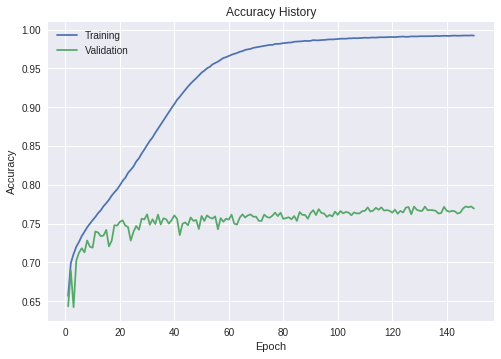

In [36]:
plt.plot(np.arange(1, 151), history.history['acc'], label='Training')
plt.plot(np.arange(1, 151), history.history['val_acc'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()

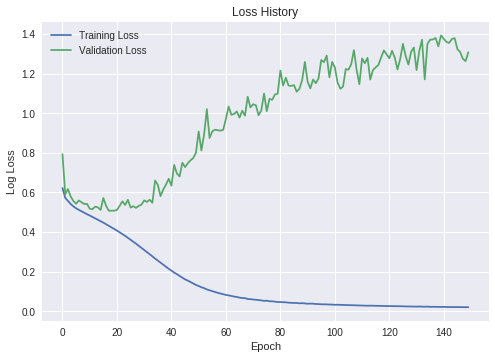

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Loss History')
plt.legend()

In [38]:
model

In [ ]:
preds = model.predict([q1_data_test, q2_data_test]).flatten()

In [53]:
classes = (preds > 0.5).astype('int').flatten()

In [56]:
generate_report(test_labels, classes.flatten(), preds.flatten())

Loss Report
-----------

Accuracy Score: 0.7685
ROC  AUC Score: 0.8255
Log Loss Score: nan


/home/ubuntu/src/anaconda3/envs/keras1.2_p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/ubuntu/src/anaconda3/envs/keras1.2_p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


(0.76849630197640195, 0.82550785414656724, nan)